# Conditional Deep Convolutional GAN (cDCGAN)

We have tried:
- Simple GAN
- Conditional GAN (cGAN)
  - Different size of FC
  - Different EPOCH
  - Different learning rate
  - Different batch size
- Conditional Deep Convolutional GAN (cDCGAN)
  - Use Conv in both G and D

We need to try:
- Conditional 'Partial' Convolutional GAN (cPCGAN)
- Use Conv only in D, only FC in G, which may solve the problem.

In [1]:
# -*- coding: utf-8 -*-
from torchvision import transforms
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from sklearn.manifold import TSNE
from time import time
from datetime import datetime
import copy
import seaborn as sns

torch.__version__

torch.manual_seed(42)

trainPath = './fashion-mnist/train.csv' # Path of data
testPath = './fashion-mnist/test.csv' # Path of data

labelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 64

learning_rate = 0.0001

In [2]:
class Sample:
    def __init__(self, idx=0, img=None, feat = None, label=None):
        self.idx = idx
        self.img = img
        self.feat = feat
        self.label = label
        
def loadImage():
    samples = []
    dataCsv = pd.read_csv(trainPath)
    dataCsvImg = dataCsv.drop(columns = 'label')
    dataCsvImg = dataCsvImg.values.astype('uint8')
    
    images = dataCsvImg.reshape(-1, 28, 28)
    labels = dataCsv['label'].values
    
    for i in range (len(images)):
        sample = Sample(idx=i, img=images[i], feat = dataCsvImg[i], label=labels[i])
        samples.append(sample)
    return samples, images, labels

allSamples, allImages, allLabels = loadImage()

In [3]:
# You need to implement this by yourself
class FashionDataset(Dataset):
    def __init__(self, inImages, inLabels, transform=None):
        self.transform = transform
        # dataCsv = pd.read_csv(trainPath)
        # dataCsvImg = dataCsv.drop(columns = 'label')
        # dataCsvImg = dataCsvImg.values.astype('uint8')
        self.images = inImages
        self.labels = inLabels
       
    def __len__(self):
       return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(Image.fromarray(self.images[idx]))
        label = self.labels[idx]
        return img, label

# transform = transforms.ToTensor()
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])
train = FashionDataset(allImages, allLabels, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


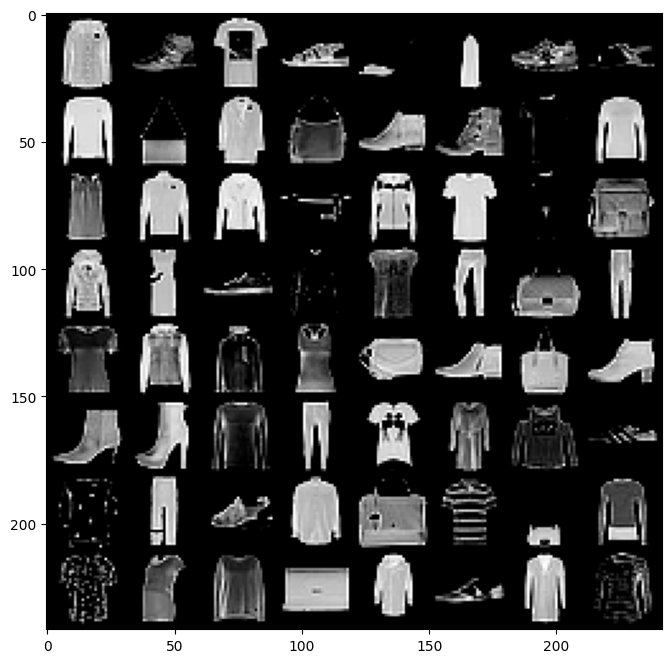

In [4]:
## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(make_grid(images[0:64],nrow=8))

In [5]:
# construct 

# layerSize = [32, 64, 128]
# layerSize = [64, 128, 256]
# layerSize = [128, 256, 512]
# layerSize = [256, 512, 1024] # 16*16

randomChannelSize = 16
randomGenerateLength = 7 # 7*7 -> 14*14 -> 28*28

class generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 10),
            nn.Linear(10, randomGenerateLength * randomGenerateLength)
        )
        
        self.random_layer = nn.Sequential(
            nn.Linear(100, randomChannelSize*randomGenerateLength*randomGenerateLength),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(randomChannelSize+1, randomChannelSize, kernel_size=4, stride=2, padding=1), # 7*7 -> 14*14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.ConvTranspose2d(randomChannelSize, randomChannelSize, kernel_size=4, stride=2, padding=1), # 14*14 -> 28*28
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # nn.Conv2d(randomChannelSize, 1, kernel_size=7, padding=3), # Channel -> 1
            # nn.Flatten(),
            # nn.Linear(1*14*14, 1*28*28),  # 14*14 -> 28*28
            # nn.Tanh()
            
            ####
            
            nn.Conv2d(randomChannelSize, 1, kernel_size=7, padding=3), # Channel -> 1
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.3),
            
            # nn.Conv2d(16, 8, kernel_size=7, padding=3), # Channel -> 1
            # nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.3),
            
            # nn.Flatten(),
            # nn.Linear(16*28*28, 1*28*28),  # 14*14 -> 28*28
            
            nn.Tanh()
        )

    def forward(self, X, labels):
        X = self.random_layer(X).view(X.shape[0], randomChannelSize, randomGenerateLength, randomGenerateLength)
        L = self.label_layer(labels).view(X.shape[0], 1, randomGenerateLength, randomGenerateLength)
        
        X = torch.cat([X, L], dim = 1)
        
        X = self.model(X)

        # X = X.view(X.shape[0], 1, 28, 28) # convert to image (matrix)
        return X

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 10),
            nn.Linear(10, 28*28)
        )
        
        self.model = nn.Sequential(
            nn.Conv2d(1+1, randomChannelSize, kernel_size=3, stride=2, padding=1), # 28*28 -> 14*14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(randomChannelSize, 2*randomChannelSize, kernel_size=3, stride=2, padding=1), # 14*14 -> 7*7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            
            nn.Linear(2*randomChannelSize*7*7, 1)
            # nn.Sigmoid()
        )
    
    def forward(self, X, labels):
        L = self.label_layer(labels).view(X.shape[0], 1, 28, 28) 
        # X = X.view(X.shape[0], 1, 28, 28)
        X = torch.cat([X, L], dim = 1)
        X = self.model(X)
        return X

In [6]:
G = generator()
D = discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = optim.Adam(D.parameters(), lr = learning_rate)

criterion = nn.BCEWithLogitsLoss() # combine sigmoid with and BCELoss

# device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('cpu')
device = torch.device('mps')

G.to(device)
D.to(device)

discriminator(
  (label_layer): Sequential(
    (0): Embedding(10, 10)
    (1): Linear(in_features=10, out_features=784, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=1, bias=True)
  )
)

EPOCH 010 finalized: discriminator loss 0.001316 - gererator loss 0.000907, time 377.863859s


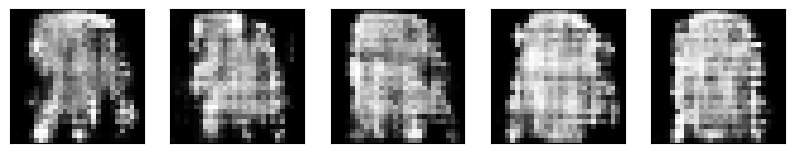

EPOCH 020 finalized: discriminator loss 0.001126 - gererator loss 0.000912, time 760.747559s


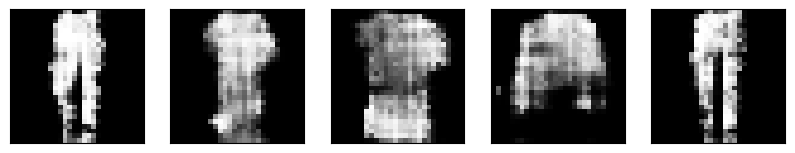

EPOCH 030 finalized: discriminator loss 0.001245 - gererator loss 0.001055, time 1151.238084s


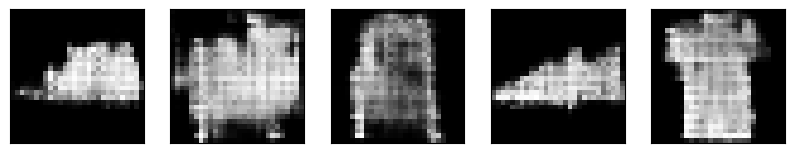

EPOCH 040 finalized: discriminator loss 0.001332 - gererator loss 0.001273, time 1537.050346s


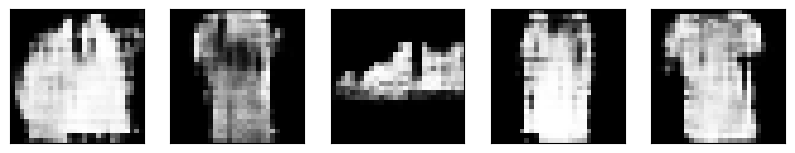

EPOCH 050 finalized: discriminator loss 0.001218 - gererator loss 0.001274, time 1908.223505s


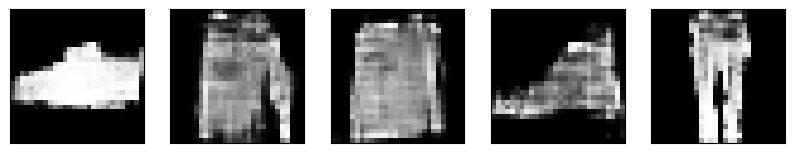

EPOCH 060 finalized: discriminator loss 0.001205 - gererator loss 0.001260, time 2286.916252s


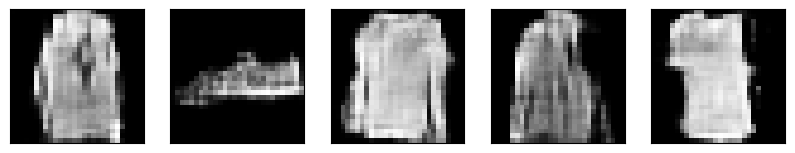

EPOCH 070 finalized: discriminator loss 0.001304 - gererator loss 0.001497, time 2666.363973s


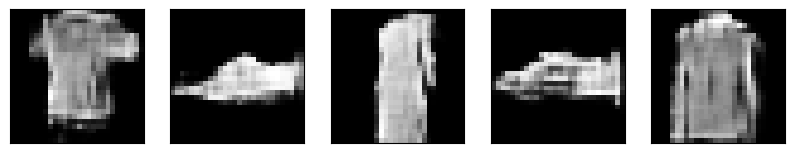

EPOCH 080 finalized: discriminator loss 0.001056 - gererator loss 0.001229, time 3047.910428s


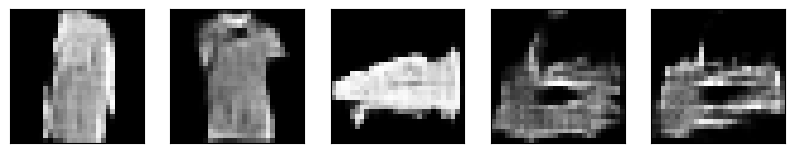

EPOCH 090 finalized: discriminator loss 0.001260 - gererator loss 0.001449, time 3435.609080s


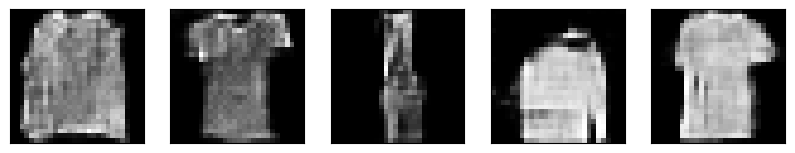

EPOCH 100 finalized: discriminator loss 0.001221 - gererator loss 0.001488, time 3814.463256s


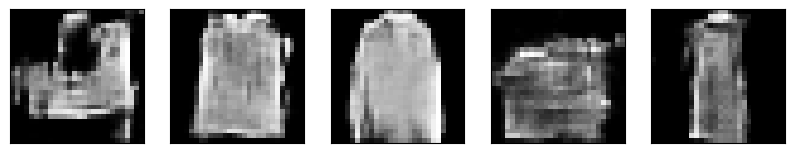

Model saved to cDCGAN2_G_16_100.pth
EPOCH 110 finalized: discriminator loss 0.001243 - gererator loss 0.001390, time 4202.674746s


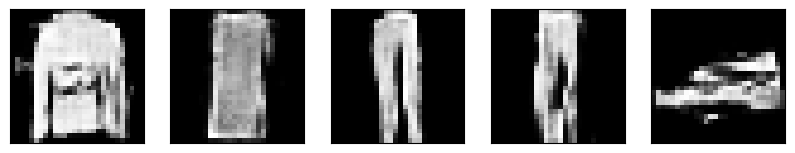

EPOCH 120 finalized: discriminator loss 0.001109 - gererator loss 0.001686, time 4592.399914s


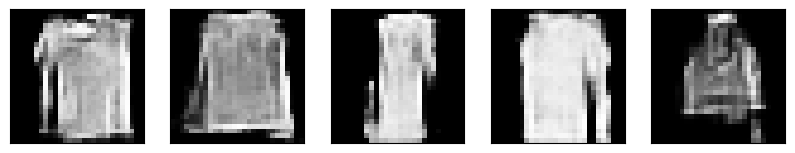

EPOCH 130 finalized: discriminator loss 0.001052 - gererator loss 0.001452, time 4990.569671s


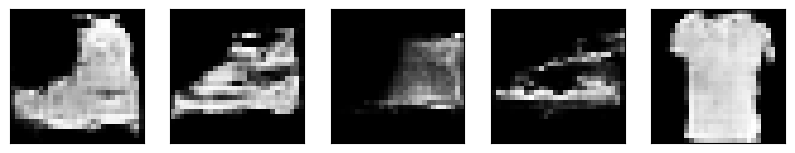

EPOCH 140 finalized: discriminator loss 0.000872 - gererator loss 0.001712, time 5394.169549s


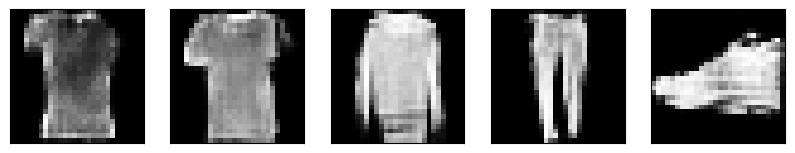

EPOCH 150 finalized: discriminator loss 0.001521 - gererator loss 0.001418, time 5771.753443s


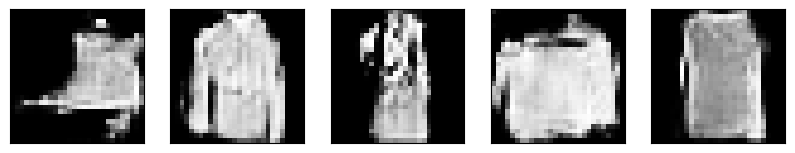

EPOCH 160 finalized: discriminator loss 0.001005 - gererator loss 0.001425, time 6143.237408s


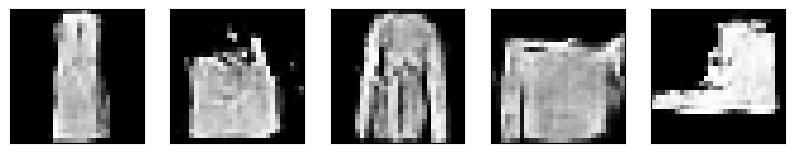

EPOCH 170 finalized: discriminator loss 0.001038 - gererator loss 0.001452, time 6513.923542s


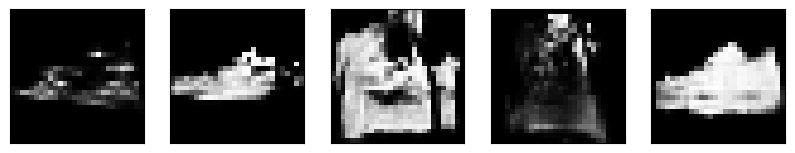

EPOCH 180 finalized: discriminator loss 0.001083 - gererator loss 0.001254, time 6890.217240s


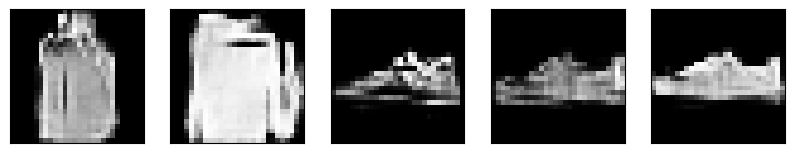

EPOCH 190 finalized: discriminator loss 0.001273 - gererator loss 0.001687, time 7259.271369s


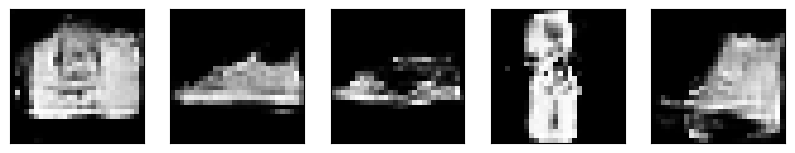

EPOCH 200 finalized: discriminator loss 0.000951 - gererator loss 0.001587, time 7630.576534s


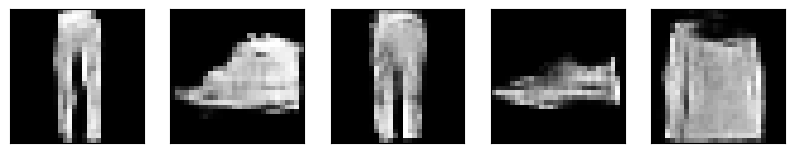

Model saved to cDCGAN2_G_16_200.pth
EPOCH 210 finalized: discriminator loss 0.001100 - gererator loss 0.001449, time 8002.799837s


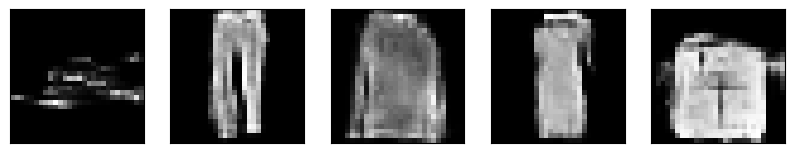

EPOCH 220 finalized: discriminator loss 0.001231 - gererator loss 0.001626, time 8373.296113s


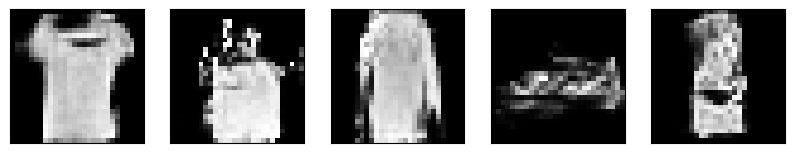

EPOCH 230 finalized: discriminator loss 0.001021 - gererator loss 0.001518, time 8746.435092s


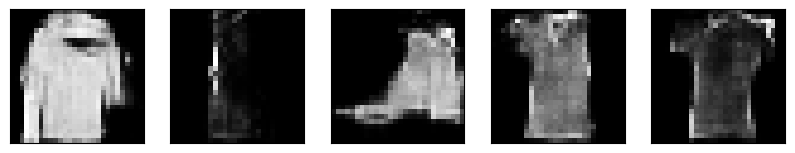

EPOCH 240 finalized: discriminator loss 0.001006 - gererator loss 0.001672, time 9118.868268s


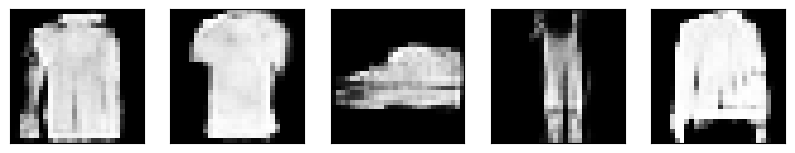

EPOCH 250 finalized: discriminator loss 0.000955 - gererator loss 0.001510, time 9492.662879s


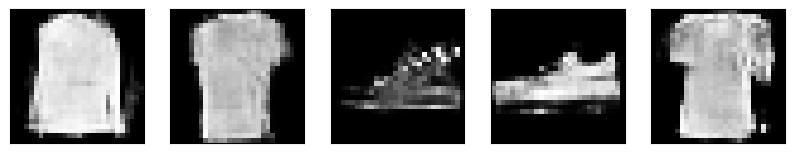

EPOCH 260 finalized: discriminator loss 0.000885 - gererator loss 0.001550, time 9868.581927s


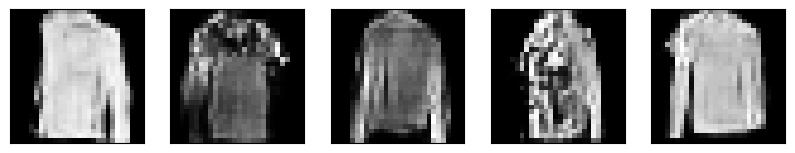

EPOCH 270 finalized: discriminator loss 0.000991 - gererator loss 0.001430, time 10241.751804s


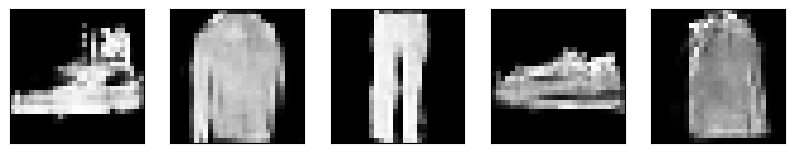

EPOCH 280 finalized: discriminator loss 0.001063 - gererator loss 0.001293, time 10622.919090s


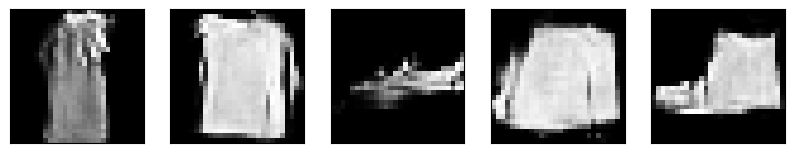

EPOCH 290 finalized: discriminator loss 0.001131 - gererator loss 0.001484, time 11008.987307s


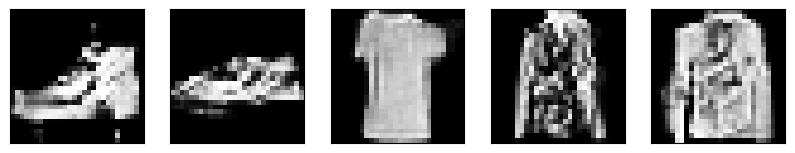

EPOCH 300 finalized: discriminator loss 0.001031 - gererator loss 0.001584, time 11389.940409s


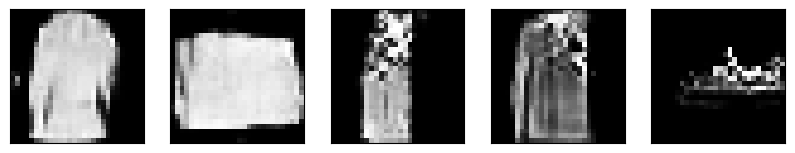

Model saved to cDCGAN2_G_16_300.pth


In [89]:
EPOCH = 300
gLoss = dict()
dLoss = dict()
startTime = datetime.now()
for epoch in range(EPOCH):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (images_real, labels_real) in enumerate(train_loader):
        batch_size = images_real.size(0)
        # images_real = images_real * 2 - 1
        images_real = images_real.to(device)
        labels_real = labels_real.to(device)

        # Train The Generator
        G_optimizer.zero_grad()
        
        random = torch.randn(batch_size, 100).to(device)
        
        # random = np.random.uniform(low=-1., high=1., size=(batch_size, 100))
        # random = torch.from_numpy(random).float().to(device)
        
        random_labels = torch.randint(low=0, high=10, size=(batch_size,), device=device)
        
        # random_labels = np.random.uniform(low=0, high=10, size=(batch_size))
        # random_labels = torch.from_numpy(random_labels).int().to(device)
        
        images_false = G.forward(random, random_labels)
        output_false = D.forward(images_false, random_labels)
        
        labels_false = torch.ones(batch_size).to(device)
        G_loss = criterion(output_false.view(*labels_false.shape), labels_false)
        G_loss.backward()
        G_optimizer.step()

        # Train The Discriminator
        D_optimizer.zero_grad()
        
        # real images
        
        outputs_real = D.forward(images_real, labels_real)
        # labels_real_false = (torch.ones(batch_size) * 0.9).to(device)
        labels_real_false = (torch.ones(batch_size)).to(device)
        D_loss_real = criterion(outputs_real.view(*labels_real_false.shape), labels_real_false)

        # false images
        random = torch.randn(batch_size, 100).to(device)
        
        # random = np.random.uniform(-1., 1., (batch_size, 100))
        # random = torch.from_numpy(random).float().to(device)
        
        random_labels = torch.randint(low=0, high=10, size=(batch_size,), device=device)
        
        # random_labels = np.random.uniform(low=0, high=10, size=(batch_size))
        # random_labels = torch.from_numpy(random_labels).int().to(device)
        
        images_false = G.forward(random, random_labels)
        outputs_false = D.forward(images_false, random_labels)
        
        labels_false = torch.zeros(batch_size).to(device)
        D_loss_false = criterion(outputs_false.view(*labels_false.shape), labels_false)

        D_loss = D_loss_real + D_loss_false
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()
        
        D_running_loss /= len(train_loader)
        G_running_loss /= len(train_loader)
        
        gLoss[epoch] = G_running_loss
        dLoss[epoch] = D_running_loss
  
    if (epoch + 1) % 10 == 0:
        endTime = datetime.now()
        duration = (endTime - startTime).total_seconds()
        # print the loss after each epoch
        print('EPOCH {:03d} finalized: discriminator loss {:03.6f} - gererator loss {:03.6f}, time {:03.6f}s'.format(epoch + 1, D_running_loss, G_running_loss, duration))

        # display 10 generated images
        random = torch.randn(10, 100).to(device)
        random_labels = np.array([i for _ in range(1) for i in range(10)])
        random_labels = torch.from_numpy(random_labels).int().to(device)
        output  = G.forward(random, random_labels).unsqueeze(1).data.to(device)
        output = output.view(10, 1, 28, 28)
        grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(figsize=(10,10))
        ax.imshow(grid)
        plt.show()
        
    if (epoch == 100):
        savePath = 'cDCGAN2_G_16_100.pth'
        torch.save(G, savePath)
        print('Model saved to {}'.format(savePath))
    elif (epoch == 200):
        savePath = 'cDCGAN2_G_16_200.pth'
        torch.save(G, savePath)
        print('Model saved to {}'.format(savePath))

savePath = 'cDCGAN2_G_16_300.pth'
torch.save(G, savePath)
print('Model saved to {}'.format(savePath))

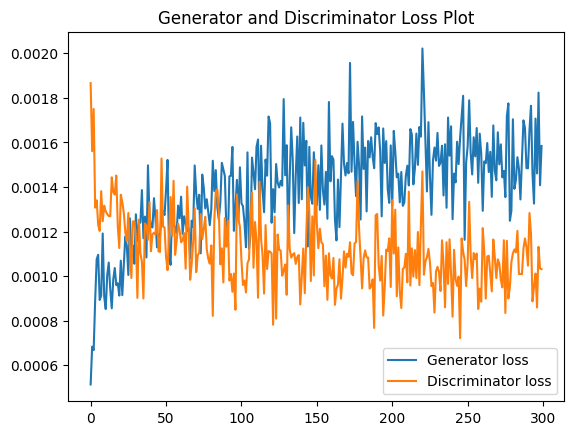

In [90]:
plt.title("Generator and Discriminator Loss Plot")
plt.plot(gLoss.keys(),gLoss.values(), label="Generator loss")
plt.plot(dLoss.keys(),dLoss.values(), label="Discriminator loss")
plt.legend()
plt.show()

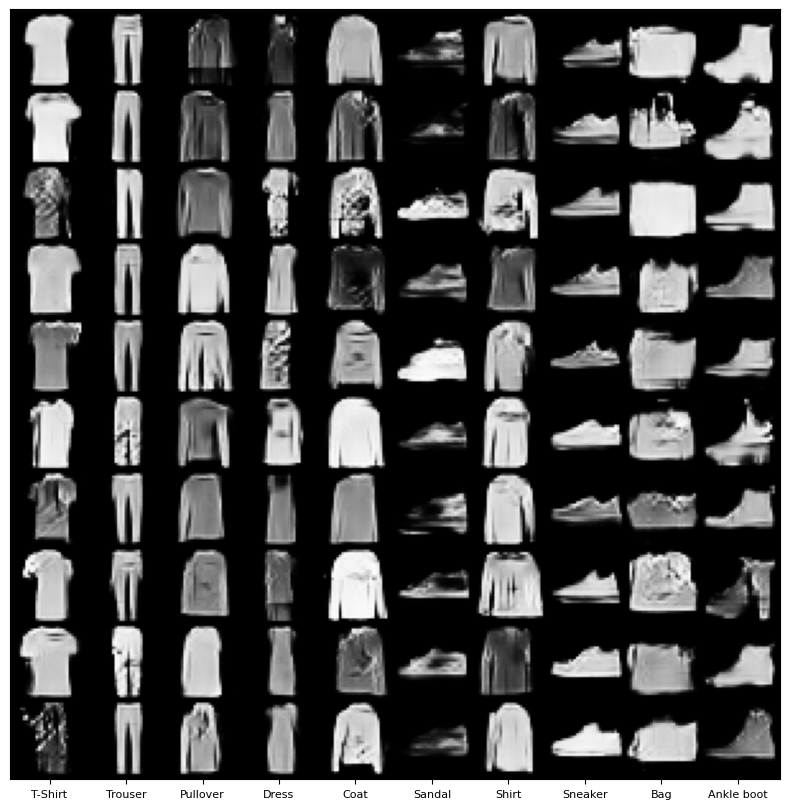

In [11]:
# loadPath = savePath
loadPath = './GAN_saved_models/cDCGAN/cDCGAN2_G_16_300.pth'
G = torch.load(loadPath)
# random = np.random.uniform(-1., 1., (100,100))
# random = torch.from_numpy(random).float().to(device)

random = torch.randn(100, 100).to(device)

# random_labels = np.array([i for _ in range(10) for i in [9]*10])

random_labels = np.array([i for _ in range(10) for i in range(10)])
random_labels = torch.from_numpy(random_labels).int().to(device)

G.eval()
output  = G.forward(random, random_labels).unsqueeze(1).data.cpu()
# output = output.cpu().detach().numpy()

output = output.view(100, 1, 28, 28)

# Show images
grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
a = plt.yticks([])
b = plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)


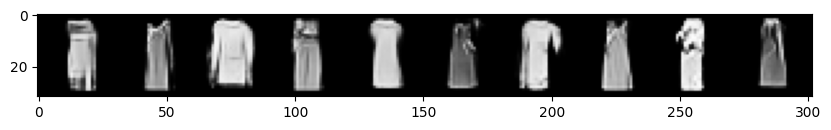

In [12]:
# generate images from a label
def generateFromLabel(inG, inLabel, inNum):
    random = torch.randn(inNum, 100).to(device)
    random_labels = np.array([i for _ in range(1) for i in [inLabel]*inNum])
    random_labels = torch.from_numpy(random_labels).int().to(device)
    inG.eval()
    output  = inG.forward(random, random_labels).unsqueeze(1).data.cpu()
    output = output.view(inNum, 1, 28, 28)
    grid = make_grid(output, nrow=inNum, normalize=True).permute(1,2,0).cpu().numpy()
    fig, ax = plt.subplots(figsize=(inNum,inNum))
    ax.imshow(grid)
    plt.show()

generateFromLabel(G, 3, 10)

<BarContainer object of 10 artists>

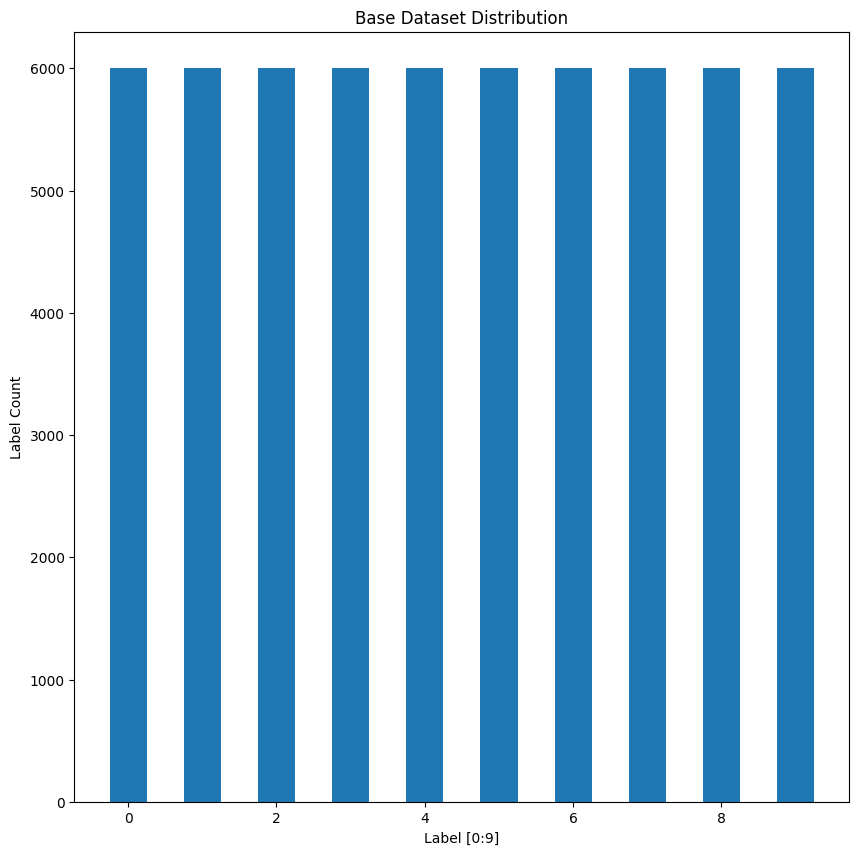

In [105]:
# Visualizations


labels = [sample.label for sample in allSamples]
keys = Counter(labels).keys()
counts = Counter(labels).values()
plt.figure(figsize=(10, 10))
plt.title("Base Dataset Distribution")
plt.xlabel("Label [0:9]")
plt.ylabel("Label Count")
plt.bar(Counter(labels).keys(),Counter(labels).values(),width=0.5)

Computing t-SNE embedding


<Figure size 2000x2000 with 0 Axes>

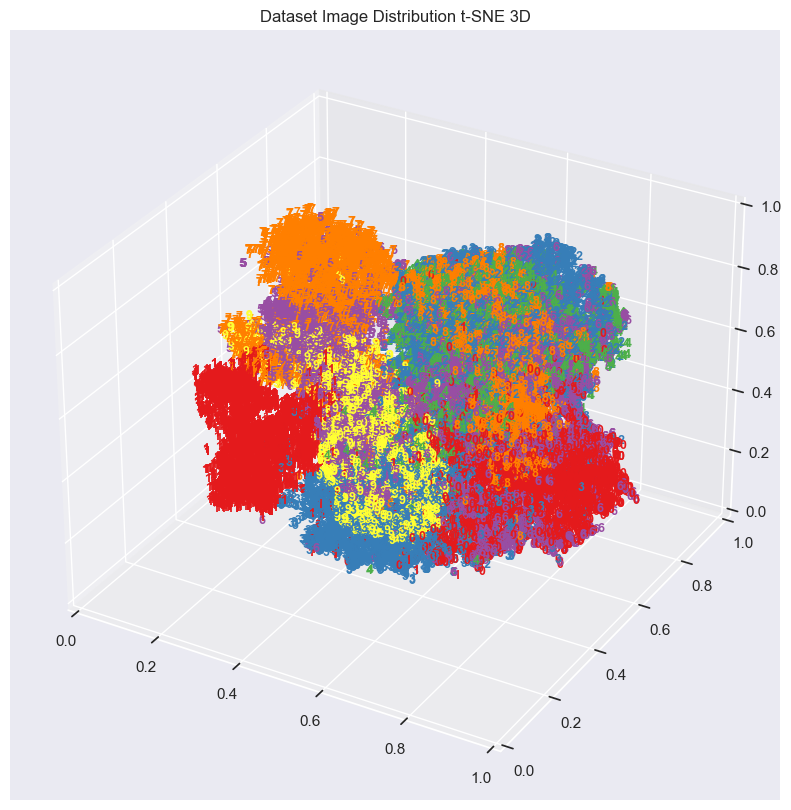

In [109]:
# check data image 3D distribution with t-NSE
X = np.array([sample.feat for sample in allSamples])
y = [sample.label for sample in allSamples]

print("Computing t-SNE embedding")
tsne = TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_o = copy.deepcopy(X)
X_tsne = tsne.fit_transform(X)

def plot_embedding_3d(X, title=None):
    plt.figure(figsize=(20, 20))    
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]), color=plt.cm.Set1(y[i] / 15.), fontdict={'weight': 'bold', 'size': 9})
        if title is not None:
            plt.title(title)

plot_embedding_3d(X_tsne,"Dataset Image Distribution t-SNE 3D")

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_84140/1049182640.py:12: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')


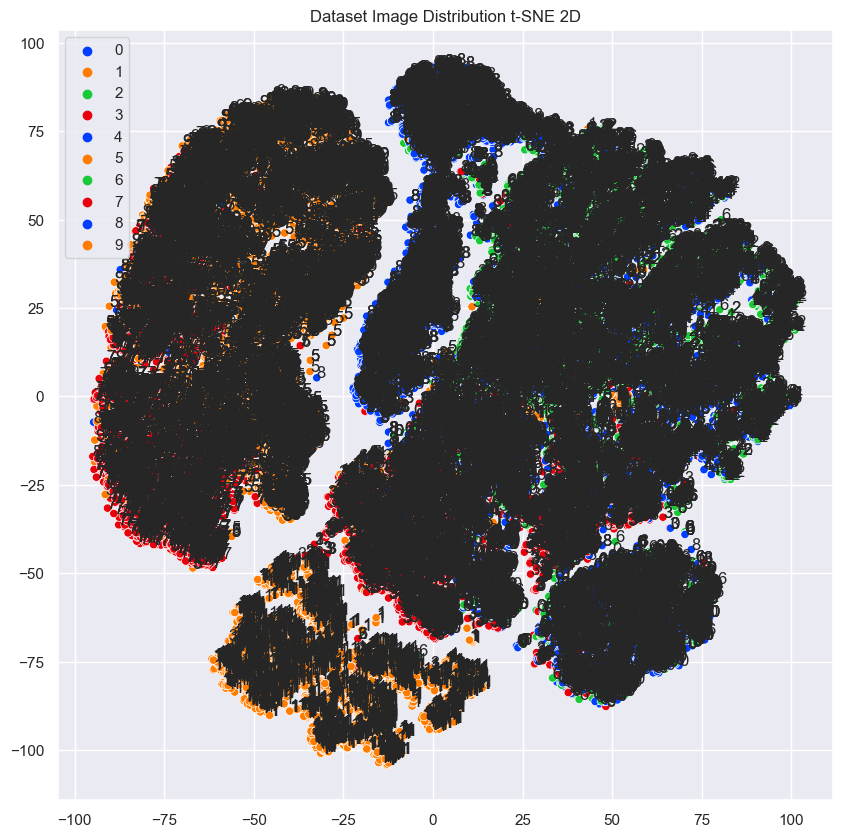

In [107]:
# check dataset pixcel feature 2D distribution with t-NSE

sns.set(rc={'figure.figsize':(10,10)}) 
palette = sns.color_palette("bright", 4) 

features = np.array([sample.feat for sample in allSamples])
labels = [sample.label for sample in allSamples]
ids = [(sample.label) for sample in allSamples]

tsne = TSNE() 
X_embedded = tsne.fit_transform(features)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')
# for i, (x, y) in enumerate(X_embedded):
#     plt.text(x, y, ids[i])

/var/folders/9c/91xx8kds77sbfz7jywfpsgnc0000gn/T/ipykernel_84140/2539749196.py:1: UserWarning: 
The palette list has fewer values (4) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')


[Text(0.5, 1.0, 'Dataset Image Distribution t-SNE 2D')]

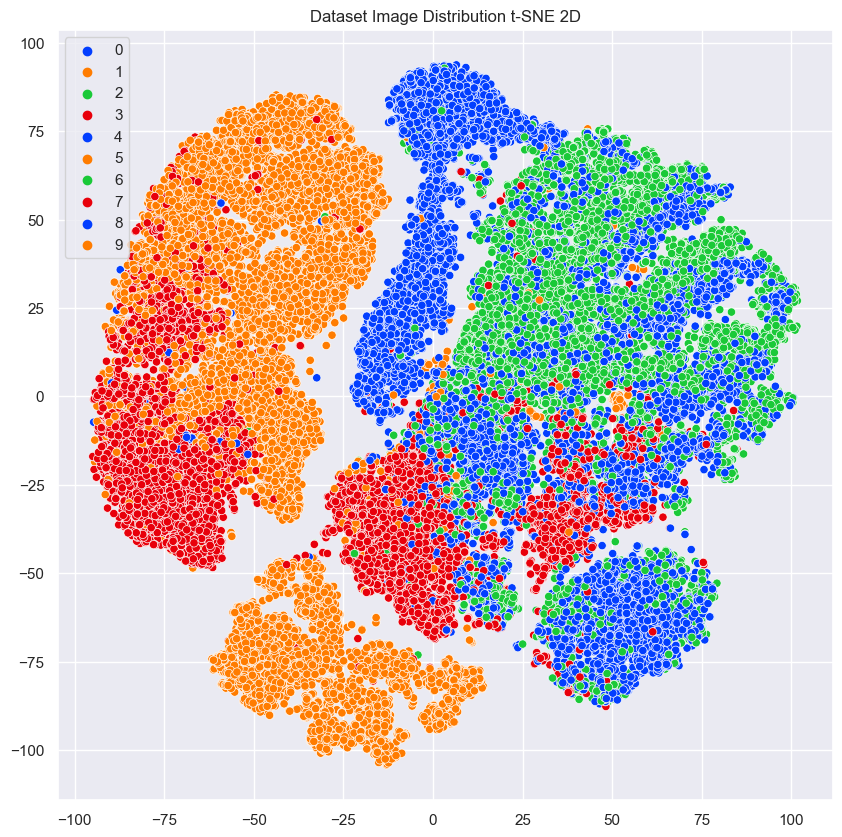

In [108]:
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], markers=ids, hue=labels, legend='full', palette=palette).set(title='Dataset Image Distribution t-SNE 2D')